## Fingerprint enhancement and minutia extraction

In this lab, we will dive into convolution, image filtering, gradients and keypoints using a fingerprint detection example. The standard fingerprint recognition process relies on a basic process: capture a clear image of a fingerprint, enhance it to clearly show ridges (fingerprint lines) and binarise (threshold to binary image), then detect minutia (fingerprint line intersections or end-points of ridges). The pattern formed by these minutia is unique, and can be used for fingerprint matching and recognition.

The accompanying images show a poor quality image of a fingerprint, taken from a foggy glass surface and a kettle. Fingerprint recognition from sources like these is called latent fingerprinting, but more challenging because we can't control the conditions the fingerprint is taken under. As part of the lab, we will losely follow the steps in this paper,

> Hong, L., Wan, Y., and Jain, A. K. Fingerprint image enhancement: Algorithm and performance evaluation. IEEE Transactions on Pattern Analysis and Machine Intelligence 20, 8 (1998), 777 789.

to improve the image quality. The basic steps outlined in this paper are, compute average gradient orientation in blocks in image. Use this gradient orientation to select Gabor filters to enhance ridges. Tune the frequency of the gabor filters to get a good response. Filter the image with these filters and combine repsonses to return an enhanced image. 

For your implementation of this, you are required to:

1. Load the image using opencv, convert it to grey scale, and crop to the region with the fingerprint.
2. Use the opencv `cv2.equalizeHist` function to improve image contrast.
3. Implement a convolution function called `my_conv` that takes in an image, a kernel or filter, and a stride, and returns the filtered image response. Your convolution function does not need to flip the kernel or perform padding. You may use the opencv conv2d function for filtering below instead, but this function won't be able to perform strided convolutions (needed below).
4. Compute the orientation of the gradient at each pixel in the image using Sobel filtering `cv2.Sobel` (see steps below).
      * First blur the image using a Gaussian kernel with a stride of 1 `cv2.GaussianBlur`.
      * Compute the horizontal and vertical Sobel derivatives respectively. Use matplotlib to show the output images.
      * Compute the gradient orientation using `atan2(Gy,Gx)`. Use matplotlib to show the output images, selecting a suitable colormap to make it easier to visualise.
      * Repeat the process above, using different size kernels and standard deviations. Choose a kernel size and standard deviation that helps pick up the gradient for the ridge lines and briefly motivate why you chose this. 
5. Design a convolutional kernel to divide the image into d x d pixel image patches and compute the average gradient orientation in each. Hint, use the stride parameter together with the averaging filter describe in the lecture videos to do this. Use `numpy.histogram` functions to compute a histogram of the orientations in this response image using k orientation bins. Use matplotlib to plot the histogram. You will need to come up with good choices for the numbers k and d. 
6. Use the gabor filter code provided to generate gabor filters for each of the orientations identified by the histogram above. Filter the image using these, and use matplotlib to show both the output images and filters. 
7. Combine all the filtered responses into a single image, by taking the maximum response at each pixel. Threshold the image to leave only those pixels greater than some threshold value. Plot the final enhanced image and try to tune the threshold value to result in the clearest fingerprint. Compare with (by plotting alongside) an approach that thresholds the original image only.   
8. Use a suitable corner detector in opencv to detect minutia (corners) in the thresholded image. Show the corners using matplotlib, and compare with corners detected directly on the original image.
9. Tune the hyperparameters (kernel size, thresholds, kernel parameters etc.) to try to get the best possible fingerprint and minutia. Try the same approach using the second image provided. Save the two best quality minutia images using the opencv `cv2.imwrite` function. Load both these images and use matplotlib to show the final results.
10. Write a brief report (max 600 words) discussing which parameters affect the fingerprint quality the most, and explaining the contribution of each step above. Explain your resoning by referencing the intermediate result figures you generated. Think about the image content and justify your choices of kernel sizes, standard deviations, frequencies, bin counts etc. Did the same parameters work for both images, explain why/ why not? What are some of the limitations of the approach above?

### Academic integrity

Every lab submission will be screened for any collusion and/or plagiarism. Breaches of academic integrity will be investigated thoroughly and may result in a zero for the assessment along with interviews with the plagiarism officers at Monash University.

### Late submissions

The default late submission university penalty will apply.

### Lab Instructions and the Use of Generative AI

You may not use any built-in opencv functions for this lab, other than those used for loading/ saving an image, extracting and matching keypoints, and
computing homographies.
* You may use NumPy for array handling, and vectorizing your code (reducing
the number of for-loops) is encouraged.
* You should use Matplotlib to display images and any intermediate results.
* You may use generative AI.

### Grading
Each lab is worth 8%, and there are a number of sections and tasks with their own weighting. A task is only considered complete if you can demonstrate a working program and show an understanding of the underlying concepts. Note that later tasks should reuse code from earlier tasks.

You will be marked based on:
* The degree to which you successfully followed the steps above and correctly implemented these.
* The quality of the fingerprint enhancement and minutia detection you finally obtained.
* The quality of your discussion and interpretation of the effects of the steps above and the choice of hyperparameters. Based on the minutia detected, comment on whether you think this method would work to recognise a fingerprint.


You may use generative AI/ coding assistance and built in opencv, matplotlib or numpy functions in this lab.

In [34]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

### Step 1: Load your image, convert to grey scale, crop and display it using matplotlib

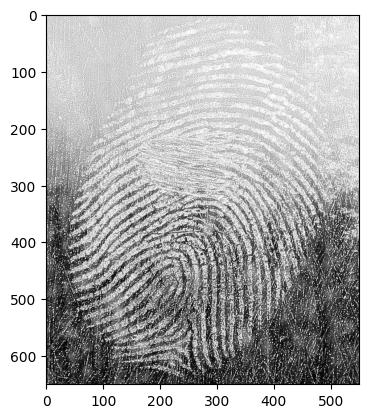

In [48]:
#import image from opencv
img = cv2.imread('glass.png')
#convert to greyscale
imgGrey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#crop image
imgGrey = imgGrey[100:750, 550:1100]
#diplay image
plt.imshow(imgGrey, cmap='gray')

### Step 2: Perform histogram equalisation and show the result using matplotlib

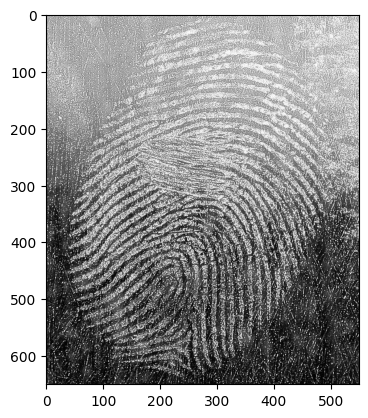

In [ ]:
#boost contrast
imgContrast = cv2.equalizeHist(imgGrey)
#display image
plt.imshow(imgContrast, cmap='gray')

### Step 3: Write your own strided convolution

In [60]:
def my_conv(img: np.ndarray, kernel: np.ndarray, stride: int):
    #Convert image to a valid datatype
    img = img.astype(np.float32)
    
    # Get kernel size
    kernel_height, kernel_width = kernel.shape
    
    # Get input image size
    img_height, img_width = img.shape
    
    # Compute output dimensions
    out_height = (img_height - kernel_height) // stride + 1
    out_width = (img_width - kernel_width) // stride + 1
    
    # Initialize output matrix
    output = np.zeros((out_height, out_width), dtype=img.dtype)

    # Perform convolution
    for i in range(out_height):
        for j in range(out_width):
            # Compute the region of interest
            start_x = i * stride
            start_y = j * stride
            
            region = img[start_x:start_x + kernel_height, start_y:start_y + kernel_width]
            
            # Apply convolution
            output[i, j] = np.sum(region * kernel)

    return output

#### Step 4: Compute the orientation of the gradient at each pixel in the image using Sobel filtering

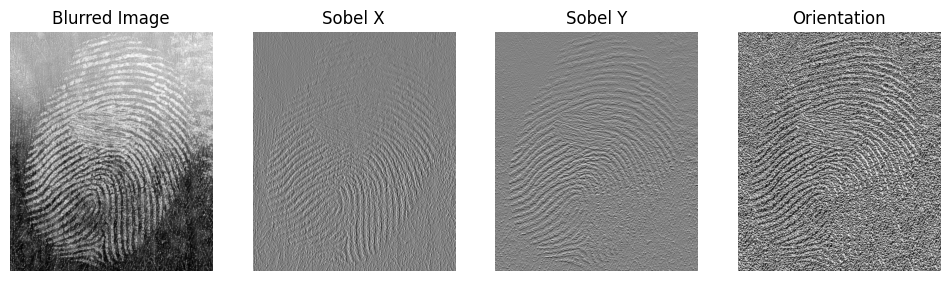

In [62]:
# Define kernels
SOBELX = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float32)

SOBELY = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
], dtype=np.float32)

Gaussian = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
], dtype=np.float32) / 16  # Normalize Gaussian kernel

# Apply the Gaussian blur first
imgBlur = my_conv(imgContrast, Gaussian, 1)

# Apply the Sobel filters to the blurred image
imgSobelX = my_conv(imgBlur, SOBELX, 1)
imgSobelY = my_conv(imgBlur, SOBELY, 1)

# Compute gradient orientation
orientation = np.arctan2(imgSobelY, imgSobelX)

# Display images
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(imgBlur, cmap='gray')
plt.title("Blurred Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(imgSobelX, cmap='gray')
plt.title("Sobel X")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(imgSobelY, cmap='gray')
plt.title("Sobel Y")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(orientation, cmap='gray')
plt.title("Orientation")
plt.axis("off")

plt.show()

#### Step 5: Compute the average orientation in image blocks and plot a histogram of the orientations

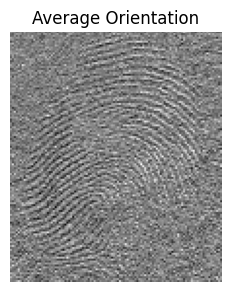

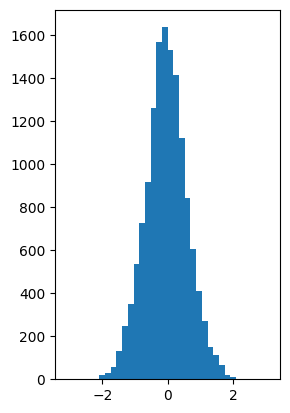

In [69]:
#define the kernal size
KERNEL_SIZE = 5
if KERNEL_SIZE % 2 == 0:
    print("Kernel size must be odd, adding 1")
    KERNEL_SIZE += 1
BINS = 36

# Define the kernel
custKernel = np.ones((KERNEL_SIZE, KERNEL_SIZE), np.float32) / (KERNEL_SIZE ** 2)
avgOri = my_conv(orientation, custKernel, KERNEL_SIZE)

#plot the image
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.imshow(avgOri, cmap='gray')
plt.title("Average Orientation")
plt.axis("off")
plt.show()

#Create histogram
plt.subplot(1, 2, 2)
plt.hist(avgOri.ravel(), bins=BINS, range=[-np.pi, np.pi])
plt.show()

#### Step 6: Generate gabor filters for each of the orientation bins above, apply these and use matplotlib to visualise both the filters and responses

In [68]:
# Given to students.
def gabor(theta,ksize,sigma,freq):
    
    kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, 10.0, freq, 0, ktype=cv2.CV_64F)
    kern /= 1.0 * kern.sum() 
    
    return kern

#### Step 7: Combine the responses above and show the enhanced image alonside the original one, then threshold the image to retain only fingerprint information

#### Step 8: Use a corner detector to try to identify Minutia

#### Step 9: Tune the hyperparameters to find the best enhanced image and best minutia detection for each images, load and show these images below.

#### Step 10: Discussion

Add a disussion here.